In [273]:
import numpy as np
import copy

letras = ["A","B","C","D","E","F","G","H"]

def validar(state,crimen=2,min_porcent=0.1):
    """
    Determina si el estado es valido, es decir ningun nodo esta desconectado
    del resto y el porcentaje minimo de cada grupo se cumple por defecto 10%
    
    Devuelve True si es valido y False en caso contrario
    
    """
    result = True
    K = len(state["matrix"])
    for i in range(K+1):
        vector=[]
        for j in range(i):
            vector.append(state["matrix"][j][i-1-j])
        if i < K:
            vector+=state["matrix"][i]
        if sum(vector) == 0:
            result = False
            break
            
    P={x:0 for x in letras[:crimen]}
    for k in state["vector_crime"]:
        if k not in P:
            P[k]=1
        else:
            P[k]+=1
    P=np.array(P.values())*1.0/sum(P.values())    
    result2=True in (P < min_porcent)
    return result and not result2
            


def generate_estate_random(size,crimen=3):
    """
    Genera un estado para la simulacion del miedo al crimen determinado por una estructura
    de comunicacion y un vector que identifica la cantidad de crimen sufrido en un periodo de 
    tiempo
    
    devuelve un diccionario de la forma
    state={"matriz":array,"vector_crime":array(n)}
    """
    
    
    state={"matrix":[],"vector_crime":[np.random.choice(letras[:crimen]) for i in range(size)]}
    for i in range(size-1):
        vector=[]
        for j in range(size-i-1):
            vector.append(np.random.randint(2))
        state["matrix"].append(vector)
    
    return state
    
def inicializacion(n_estados,size,crimen=3,min_porcent=0.1):
    Poblacion=[]
    while(len(Poblacion) != n_estados):
        s=generate_estate_random(size,crimen)
        if validar(s,crimen,min_porcent) == True and s not in Poblacion:
            Poblacion.append(s)
    return Poblacion

def convert_matrix_to_vecinos(state):
    M=state["matrix"]
    C=state["vector_crime"]
    vecinos=[[i,c] for i,c in zip(range(len(M)+1), C)]
    for i in range(len(M)):
        for j in range(len(M[i])):
            if M[i][j] == 1 :
                vecinos[i].append(j+i+1)
                vecinos[j+i+1].append(i)
    return vecinos

def generate(vertices,psi,nu,T=200,s=np.array([None]),lamda={"A":0,"B":0.05,"C":0.5}):
    n=len(vertices)
    
    #periodos en semanas
    #T=150 #6 aos
    if s.all() == None:
        s = np.random.rand(n)  # vector PoS de las personas en el intante t, al principio aleatorio
        
        
    #psi = 0.9  # velocidad perdida de memoria
    #nu = 0.85  # Impacto de la inseguridad
    
    St = np.zeros((T,n ))  # PoS a lo largo del tiempo
    #identificacion de cada sujeto con su respectiva media de crimen
    
    St[0] = s
    
    for t in range(1,T):
        
        # Al inicio de cada periodo aplicamos la perdida de memoria
        s = psi * s       
        ## crimen
        for k in range(n):
            # numero de crimenes sufridos por la persona k 
            X = np.random.poisson(lamda[vertices[k][1]])
            # posicion hubo crimen o no
            I = 0
            if X >= 1:  # si hubo al menos un crimen I=1 de lo contrario I=0
                I = 1
            # efecto del crimen en la percepcion de k para el siguiente periodo
            s[k] = I + (1 - I) * s[k] 

        #comunicacion 

        #copia
        scopia=s.copy()
        
        for k in range(n):
            vecinos = vertices[k][2:]
            media = 0
            for vecino in vecinos:
                media+=scopia[vecino]
            media=media*1.0/len(vecinos)

            if scopia[k] > media:
                s[k]=nu*scopia[k]+(1-nu)*media
            else:
                s[k]=(1-nu)*scopia[k]+nu*media

        St[t] = s
        
        promedio=0
        for i in range(n):
            promedio+=np.mean(St.T[i][100:])
        promedio=promedio/100.0
        
    
    return St, promedio

def homofilia(vertices):
    edges={}
    for vertice in vertices:
        for vecino in vertice[2:]:
            if (vertice[0],vecino) in edges or (vecino,vertice[0]) in edges:
                pass
            else:
                edges[(vertice[0],vecino)]= 1*(vertice[1] == vertices[vecino][1])
    return sum(edges.values())*1.0/len(edges)

def funcion_objetivo(state,s0):
    v=convert_matrix_to_vecinos(state)
    S=generate(v,0.98,0.85,T=200,s=s0)[1]
    return np.cos(S)+np.cos(homofilia(v))
      
def seleccion(Poblacion,s):
    fdp=[]
    for i in range(len(P)):
        fdp.append(funcion_objetivo(P[i],s))
    
    fdp=fdp/sum(fdp)

    return fdp

def sample(Poblacion,fdp):
    return np.random.choice(Poblacion,p=fdp)


def combinacion(state1,state2):
    
    k1=len(state1["matrix"])
    k2=k1+1
    
    hijo1=copy.deepcopy(state1)
    hijo2=copy.deepcopy(state2)
    
    rand1=np.random.randint(k1+1)
    
    
    for i in range(len(state1["matrix"])):
        for j in range(len(state1["matrix"][i])):
            if j < rand1:
                hijo1["matrix"][i][j]=state1["matrix"][i][j]
                hijo2["matrix"][i][j]=state2["matrix"][i][j]
            else:
                hijo1["matrix"][i][j]=state2["matrix"][i][j]
                hijo2["matrix"][i][j]=state1["matrix"][i][j]
                
    rand2=np.random.randint(k2+1)
    for i in range(len(state1["vector_crime"])):
        if i < rand2:
            hijo1["vector_crime"][i]=state1["vector_crime"][i]
            hijo2["vector_crime"][i]=state2["vector_crime"][i]
        else:
            hijo1["vector_crime"][i]=state2["vector_crime"][i]
            hijo2["vector_crime"][i]=state1["vector_crime"][i]
        
    return [hijo1,hijo2]    

def mutacion(state,crimen,probabilidad=None,min_porcent=0.1):
    
    copia=copy.deepcopy(state)
    
    if not probabilidad:
        probabilidad=1.0/len(state["vector_crime"])
    
    if np.random.binomial(1,probabilidad) == 1:
        rand1=np.random.randint(len(copia["vector_crime"]))
        anterior=copia["vector_crime"][rand1]
        
        while copia["vector_crime"][rand1] == anterior:
            copia["vector_crime"][rand1] = np.random.choice(letras[:crimen])
            
        rand2=np.random.randint(len(copia["matrix"]))
        rand3=np.random.randint(len(copia["matrix"][rand2]))
        
        if copia["matrix"][rand2][rand3] == 0:
            copia["matrix"][rand2][rand3] = 1
        else:
            copia["matrix"][rand2][rand3] = 0 
                     
        if validar(state=copia,crimen=crimen,min_porcent=min_porcent) == True:
            state=copia
    return state

def plot(vertices,s):
    import seaborn as sn
    import matplotlib.pyplot as plt
    colors=["R","B","G"]
    S=generate(vertices,0.9,0.85,100,s)[0].T
    
    promedio=0
    for i in range(20):
        promedio+=np.mean(S.T[i])
    promedio=promedio/20.0
        
    
    
    G={}
    for vertice in vertices:
        if vertice[1] not in G:
            G[vertice[1]]=[]
        G[vertice[1]].append(vertice[0])
        
    
    contador = 0
    for grupo in G.keys():
        sn.tsplot(S[G[grupo]],color=colors[contador],ci='sd')
        contador+=1

    plt.legend([str(k) for k in G.keys()])
    plt.xlabel("Time")
    plt.ylabel("Fear of crime")
    return promedio
    

1.875958568992854
1.8864589627231947
1.8901194888475146
1.8906344850847308
1.894369287089857
1.896493902516135
1.897917111480627
1.8991005921002162
1.9031376249931644
1.906761438666414


0.4719834096385864

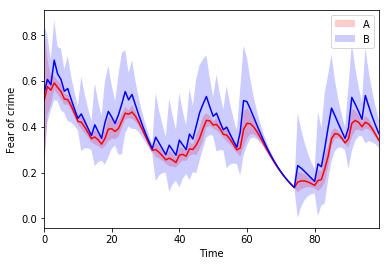

In [279]:
nodos=20
crimen=2
min_porcent=0.1

#Inicializacion de la poblacion
P=inicializacion(n_estados=10,crimen=crimen,min_porcent=min_porcent,size=nodos)
#Estado inicial miedo al crimen para cada nodo
s0=np.random.rand(nodos)

total_generaciones=10
#### for generaciones

for i in range(total_generaciones):
    puntaje_generacion=[]
    for estado in P:
        puntaje_generacion.append(funcion_objetivo(estado,s0))

    print(np.mean(puntaje_generacion))


    #funcion densidad de probabilidad para muestrear estados de la poblacion actual que depende de su desempeño
    fdp=seleccion(Poblacion=P,s=s0)

    #Hijos de la poblacion actual
    Nueva_Generacion=[]

    # Combinacion 
    while len(Nueva_Generacion) != len(P):
        padre1=sample(Poblacion=P,fdp=fdp)
        padre2=sample(Poblacion=P,fdp=fdp)
        hijos=combinacion(state1=padre1,state2=padre2)
        while (validar(state=hijos[0],crimen=crimen,min_porcent=min_porcent) and validar(state=hijos[1],crimen=crimen,min_porcent=min_porcent)) == False:
            hijos=combinacion(state1=padre1,state2=padre2)
        Nueva_Generacion+=hijos

    # Mutacion
    for i in range(len(Nueva_Generacion)):
        Nueva_Generacion[i]=mutacion(Nueva_Generacion[i],crimen)

    # Reemplazo

    total = P+Nueva_Generacion

    fo=[]
    for t in total:
        fo.append(funcion_objetivo(t,s0))
    order=np.argsort(fo)[::-1]
    best=order[:len(P)]
    for i in range(len(P)):
        P[i]=total[best[i]]

plot(convert_matrix_to_vecinos(P[0]),s0)


In [280]:
np.mean(s0)

0.5290088447351343

1.8356672642153207
1.841756666305579
1.8438956863863658
1.845579195276995
1.8459158041330546
1.8462822130999623
1.8469262327777343
1.8472947443183942
1.8477983482159874
1.848689458223258
1.8492266722773196
1.8497987774558042
1.8513482878200096
1.852500918101799
1.8537562831005743
1.854847016811606
1.8555606554073292
1.856288114735794
1.8568985409166068
1.857212934050764
1.857091024591804
1.857330630210801
1.8572672710252627
1.857308979286679
1.8572856988647688
1.8574698683523083
1.857651305036107
1.8577449103521737
1.8579138073839792
1.8581948112483486
1.8586874332215682
1.8590249057111026
1.8590970460821663
1.8591565718388199
1.8594110720179748
1.8594059911225667
1.8594738854404178
1.8595992593052324
1.8595233375025328
1.8597387282912108
1.8598576796878012
1.8599573272168632
1.859954814065522
1.8600898585317414
1.8600654959309133
1.860129565103211
1.8603467042155089
1.8605850422749262
1.8605422518843198
1.860730289795198


0.7117603509737981

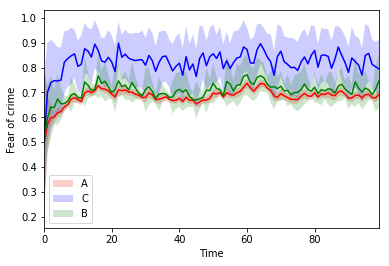

In [281]:
nodos=50
crimen=3
min_porcent=0.1

#Inicializacion de la poblacion
P=inicializacion(n_estados=30,crimen=crimen,min_porcent=min_porcent,size=nodos)
#Estado inicial miedo al crimen para cada nodo
s0=np.random.rand(nodos)

total_generaciones=50
#### for generaciones

for i in range(total_generaciones):
    puntaje_generacion=[]
    for estado in P:
        puntaje_generacion.append(funcion_objetivo(estado,s0))

    print(np.mean(puntaje_generacion))


    #funcion densidad de probabilidad para muestrear estados de la poblacion actual que depende de su desempeño
    fdp=seleccion(Poblacion=P,s=s0)

    #Hijos de la poblacion actual
    Nueva_Generacion=[]

    # Combinacion 
    while len(Nueva_Generacion) != len(P):
        padre1=sample(Poblacion=P,fdp=fdp)
        padre2=sample(Poblacion=P,fdp=fdp)
        hijos=combinacion(state1=padre1,state2=padre2)
        while (validar(state=hijos[0],crimen=crimen,min_porcent=min_porcent) and validar(state=hijos[1],crimen=crimen,min_porcent=min_porcent)) == False:
            hijos=combinacion(state1=padre1,state2=padre2)
        Nueva_Generacion+=hijos

    # Mutacion
    for i in range(len(Nueva_Generacion)):
        Nueva_Generacion[i]=mutacion(Nueva_Generacion[i],crimen)

    # Reemplazo

    total = P+Nueva_Generacion

    fo=[]
    for t in total:
        fo.append(funcion_objetivo(t,s0))
    order=np.argsort(fo)[::-1]
    best=order[:len(P)]
    for i in range(len(P)):
        P[i]=total[best[i]]

plot(convert_matrix_to_vecinos(P[0]),s0)


In [282]:
np.mean(s0)

0.5026177896900595

In [283]:
vecinos=convert_matrix_to_vecinos(P[0])

In [284]:
for v in vecinos:
    print(v)

[0, 'B', 3, 4, 8, 10, 12, 16, 19, 21, 22, 23, 24, 25, 27, 38, 39, 40, 43, 44, 47, 49]
[1, 'C', 2, 3, 4, 6, 9, 10, 12, 14, 15, 17, 18, 19, 21, 26, 27, 28, 31, 32, 35, 36, 38, 40, 41, 44, 45, 46, 48]
[2, 'B', 1, 4, 5, 7, 10, 11, 12, 14, 19, 20, 21, 22, 26, 30, 32, 33, 35, 36, 37, 38, 39, 41, 44, 45, 47]
[3, 'A', 0, 1, 4, 5, 7, 9, 10, 12, 13, 18, 20, 21, 22, 26, 27, 30, 31, 36, 41, 42, 45, 47, 48, 49]
[4, 'C', 0, 1, 2, 3, 5, 8, 9, 11, 13, 27, 28, 29, 30, 31, 34, 38, 41, 42, 44, 46, 47, 48, 49]
[5, 'A', 2, 3, 4, 7, 8, 11, 12, 13, 14, 17, 18, 19, 20, 23, 25, 26, 29, 31, 33, 34, 35, 41, 42, 45, 48]
[6, 'B', 1, 11, 12, 16, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 40, 46, 48, 49]
[7, 'B', 2, 3, 5, 9, 10, 12, 13, 14, 16, 21, 24, 25, 26, 27, 28, 31, 32, 33, 37, 38, 39, 41, 44, 45, 47, 48, 49]
[8, 'C', 0, 4, 5, 14, 16, 17, 21, 25, 28, 32, 34, 35, 37, 42, 45, 46, 48, 49]
[9, 'C', 1, 3, 4, 7, 10, 11, 12, 17, 23, 24, 27, 28, 31, 32, 33, 36, 38, 39, 42, 45, 48]
[10, 'A', 0,